In [1]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import time
import sys 
import seaborn as sns
from sklearn.metrics import f1_score, recall_score
from tensorflow.keras.layers import AveragePooling2D
import cv2
import re
import pandas as pd
from utils import *

sys.path.append("./models/GPA")
from useful_functions import *
sys.path.append("./models/robust-pca-master/")

In [2]:
dataset_name = "pedestrians"
result_path = f"./dataset/results/{dataset_name}"
img_path = f"./dataset/baseline/{dataset_name}/"
print(result_path, img_path)

./dataset/results/pedestrians ./dataset/baseline/pedestrians/


In [3]:
# Ground Truth Files
gt_files = glob.glob(img_path + "groundtruth/*png")
gt_files.sort()

# Raw Image Failes
raw_files = glob.glob(img_path + "input/*jpg")
raw_files.sort()

print(len(gt_files), len(raw_files))

1099 1099


In [4]:
def assert_same_gtraw(name1, name2):
    name1 = re.findall(r"gt.+\.png", name1)[0]
    index1 = re.findall("\d+", name1)[0]
    name2 = re.findall(r"in.+\.jpg", name2.split('/')[-1])[0]
    index2 = re.findall("\d+", name2)[0]
    assert index1 == index2

In [5]:
# Example Ground Truth
i =950
gt_img = Image.open(gt_files[i])
gt_img = np.array(gt_img).astype(np.int32) / 255.0
gt_img = (gt_img > 0.5) * 1.0
gt_img.shape

(240, 360)

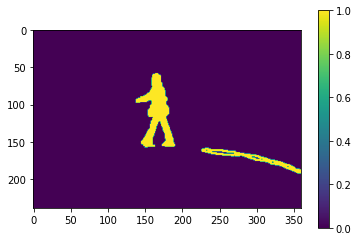

In [6]:
plt.imshow(gt_img)
plt.colorbar()

In [7]:
# Example Raw Image
raw_img = Image.open(raw_files[i])
raw_img = np.array(raw_img).astype(np.int32) / 255.0

In [11]:
p, q = raw_img.shape[0:2]

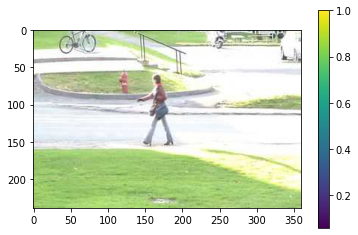

In [12]:
plt.imshow(raw_img)
plt.colorbar()

# GPA

In [10]:
G = 500               # number of grid points
p = raw_img.shape[0]
q = raw_img.shape[1]
N0 = len(raw_files)   # number of images to compute the GPA matrix


alpha = np.log(p * q) / np.log(N0)
bandwidth, bandwidth_star = compute_optimal_bandwidths(N0, alpha)

Optimal bandwidth from Rule of Thumb: 0.01679044266040761
Optimal bandwidth* from GPA estimation: 0.001409594823662179


In [26]:
# rng = np.random.default_rng(seed=0)

# # tick list
# tick_list = rng.random(size=G)
# tick_tensor = tf.concat([tf.ones([1, p, q]) * tick for tick in tick_list], axis=0)

# # GPA matrix
# j = 0
# GPA_matrix = tf.zeros([G, p, q])

# # 【尝试】使用全部的数据
# n = len(raw_files)
# for i in range(n):
#     print(f"--Load the {j}th image to compute GPA matrix with [index={i}]--")
#     test_img = load_and_preprocess_image(raw_files[i], (p, q))
#     tmp_tensor = (1 / (n * bandwidth)) * (1 / tf.sqrt(2*np.pi)) * tf.exp(-(test_img - tick_tensor)**2 / (2 * bandwidth**2))
#     GPA_matrix += tmp_tensor
#     j += 1

--Load the 0th image to compute GPA matrix with [index=0]--
--Load the 1th image to compute GPA matrix with [index=1]--
--Load the 2th image to compute GPA matrix with [index=2]--
--Load the 3th image to compute GPA matrix with [index=3]--
--Load the 4th image to compute GPA matrix with [index=4]--
--Load the 5th image to compute GPA matrix with [index=5]--
--Load the 6th image to compute GPA matrix with [index=6]--
--Load the 7th image to compute GPA matrix with [index=7]--
--Load the 8th image to compute GPA matrix with [index=8]--
--Load the 9th image to compute GPA matrix with [index=9]--
--Load the 10th image to compute GPA matrix with [index=10]--
--Load the 11th image to compute GPA matrix with [index=11]--
--Load the 12th image to compute GPA matrix with [index=12]--
--Load the 13th image to compute GPA matrix with [index=13]--
--Load the 14th image to compute GPA matrix with [index=14]--
--Load the 15th image to compute GPA matrix with [index=15]--
--Load the 16th image to com

In [49]:
filter_size = 3
location_filter = get_location_filter(p, q, bandwidth, filter_size)

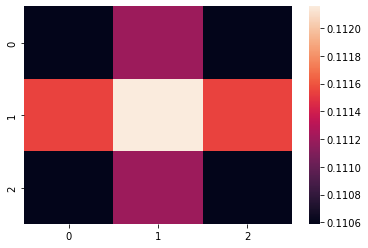

In [50]:
# show the location filter in heatmap
sns.heatmap(location_filter[:, :, 0, 0])
plt.show()

In [51]:
GPA_matrix2 = tf.reshape(GPA_matrix, GPA_matrix.shape + (1,))
# second layer smoothing
GPA_matrix2 = tf.nn.depthwise_conv2d(GPA_matrix2, location_filter, strides=[1, 1, 1, 1], padding='SAME')
GPA_matrix2 = tf.squeeze(GPA_matrix2)

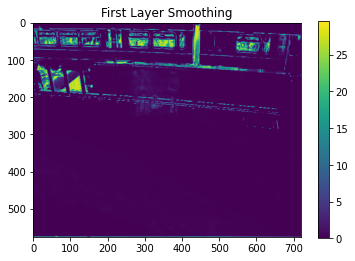

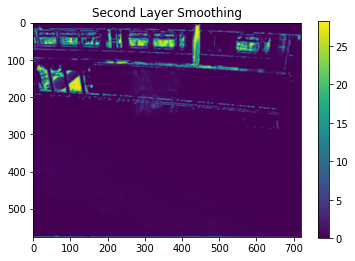

In [52]:
plt.imshow(GPA_matrix[2, :, :])
plt.title(f"First Layer Smoothing")
plt.colorbar()
plt.show()
plt.imshow(GPA_matrix2[2, :, :])
plt.title(f"Second Layer Smoothing")
plt.colorbar()
plt.show()

## GPA 图片密度估计

In [55]:
# Example Ground Truth
i = 299
# ground truth and raw image
gt_img = np.array(Image.open(gt_files[i])).astype(np.int32) / 255.0
gt_img = (gt_img > 0.5) * 1.0

# Example Raw Image
raw_img = Image.open(raw_files[i])
raw_img = np.array(raw_img).astype(np.int32) / 255.0
test_img = raw_img.mean(axis=2)

In [56]:
gt_img.sum()

2910.0

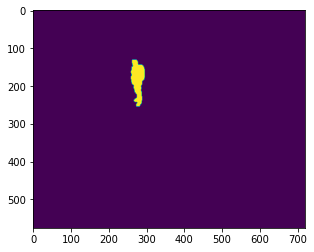

In [57]:
plt.imshow(gt_img)

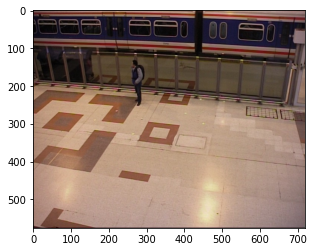

In [58]:
plt.imshow(raw_img)

In [59]:
# GPA 估计
t1 = time.time()
Omega2_star = K_tf(tick_tensor - test_img, bandwidth_star)
print(Omega2_star.shape)
Omega1_star = Omega2_star * GPA_matrix2
Omega1_star = tf.reduce_sum(Omega1_star, axis=0)
Omega2_star = tf.reduce_sum(Omega2_star, axis=0)
GPA_density = Omega1_star / Omega2_star
t2 = time.time()
print(f"Computing GPA Density Time: {t2 - t1}")

(500, 576, 720)
Computing GPA Density Time: 0.005019187927246094


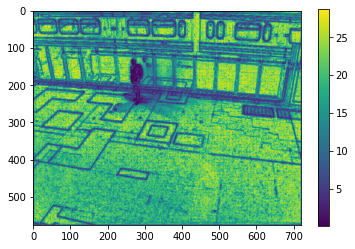

In [60]:
plt.imshow(GPA_density)
plt.colorbar()
plt.show()

In [145]:
# blur_len = 5
# avg_blur_2d = AveragePooling2D(pool_size=(blur_len, blur_len), strides=1, padding='same')
# GPA_density2 = tf.reshape(GPA_density, GPA_density.shape + (1, 1,))
# GPA_density2 = avg_blur_2d(GPA_density2)
# GPA_density2 = tf.squeeze(GPA_density2)

GPA_density2 = GPA_density

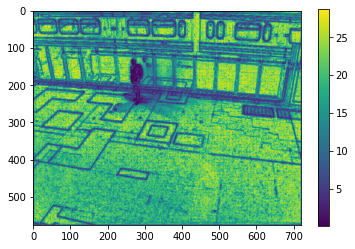

In [146]:
plt.imshow(GPA_density2)
plt.colorbar()
plt.show()

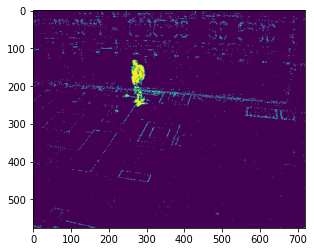

In [148]:
mask = (GPA_density2.numpy() < 3) * 1.0
plt.imshow(mask)

In [149]:
mask_uint8 = mask.astype(np.uint8)
_, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8)
# stats = np.insert(stats, 5, stats[:, 2] * stats[:, 3], axis=1)
stats = stats[np.argsort(-stats[:, 4])] # 按照area排序
stats = stats[1:, ]                     # 去掉背景
stats[:5, ]

array([[ 259,  131,   38,   69, 1587],
       [ 264,  200,   41,   56,  780],
       [ 237,  222,   33,    9,   85],
       [ 314,  213,   23,    5,   56],
       [ 285,  297,   20,   36,   49]], dtype=int32)

In [150]:
for k in range(stats.shape[0]):
    area = stats[k, 4]
    if area < 50:
        print(f"delete the {k}th area")
        x1 = stats[k, 0]
        y1 = stats[k, 1]
        x2 = x1 + stats[k, 2]
        y2 = y1 + stats[k, 3]
        mask[y1:y2, x1:x2] = 0

delete the 4th area
delete the 5th area
delete the 6th area
delete the 7th area
delete the 8th area
delete the 9th area
delete the 10th area
delete the 11th area
delete the 12th area
delete the 13th area
delete the 14th area
delete the 15th area
delete the 16th area
delete the 17th area
delete the 18th area
delete the 19th area
delete the 20th area
delete the 21th area
delete the 22th area
delete the 23th area
delete the 24th area
delete the 25th area
delete the 26th area
delete the 27th area
delete the 28th area
delete the 29th area
delete the 30th area
delete the 31th area
delete the 32th area
delete the 33th area
delete the 34th area
delete the 35th area
delete the 36th area
delete the 37th area
delete the 38th area
delete the 39th area
delete the 40th area
delete the 41th area
delete the 42th area
delete the 43th area
delete the 44th area
delete the 45th area
delete the 46th area
delete the 47th area
delete the 48th area
delete the 49th area
delete the 50th area
delete the 51th are

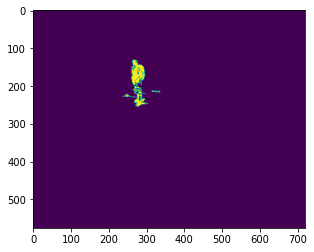

In [151]:
plt.imshow(mask)

In [152]:
y_predict = mask.ravel()
y_true = gt_img.ravel()
f1 = f1_score(y_true, y_predict)     # F1-score
recall = recall_score(y_true, y_predict) #recall
print(f1, recall)

0.8025101513473606 0.7470790378006873


In [96]:
print(f1, recall)

0.8025101513473606 0.7470790378006873


# mean performance

In [157]:
time_list = []
metrics_list = []  # f1score, recall
debug = 0

for i in range(len(gt_files)):
    # ground truth and raw image
    gt_img = np.array(Image.open(gt_files[i])).astype(np.int32) / 255.0
    gt_img = (gt_img > 0.5) * 1.0
    y_true = gt_img.ravel()
    if np.sum(y_true) < 100:
        continue
    
    raw_img = load_and_preprocess_image(raw_files[i], (p, q))
    if debug:
        plt.imshow(gt_img)
        plt.title("gt_img")
        plt.show()
    
    # GPA density estimator
    t1 = time.time()
    Omega2_star = K_tf(tick_tensor - raw_img, bandwidth_star)
    print(Omega2_star.shape)
    Omega1_star = Omega2_star * GPA_matrix2
    Omega1_star = tf.reduce_sum(Omega1_star, axis=0)
    Omega2_star = tf.reduce_sum(Omega2_star, axis=0)
    GPA_density = Omega1_star / Omega2_star
    
    # obtain mask
#     blur_len = 3
#     avg_blur_2d = AveragePooling2D(pool_size=(blur_len, blur_len), strides=1, padding='same')
#     mask = tf.reshape(GPA_density, GPA_density.shape + (1, 1,))
#     mask = avg_blur_2d(mask)
#     mask = tf.squeeze(mask)
    mask = (GPA_density.numpy() < 3) * 1.0
    if debug:
        plt.imshow(mask)
        plt.title("mask")
        plt.show()

    # adjust mask
    mask_uint8 = mask.astype(np.uint8)
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8)
    # stats = np.insert(stats, 5, stats[:, 2] * stats[:, 3], axis=1)
    stats = stats[np.argsort(-stats[:, 4])] # 按照area排序
    stats = stats[1:, ]                     # 去掉背景
    
    for k in range(stats.shape[0]):
        area = stats[k, 4]
        if area < 50:
            x1 = stats[k, 0]
            y1 = stats[k, 1]
            x2 = x1 + stats[k, 2]
            y2 = y1 + stats[k, 3]
            mask[y1:y2, x1:x2] = 0
    t2 = time.time()
    time_list.append(t2 - t1)
    if debug:
        print(stats)
        plt.imshow(mask)
        plt.title("final mask")
        plt.show()
    
    # metrics
    y_predict = mask.ravel()
    f1 = f1_score(y_true, y_predict)
    recall = recall_score(y_true, y_predict)
    metrics_list.append([f1, recall])
    print(f"[{i}] f1:{f1:5f}\trecall:{recall:5f}\t Time: {time_list[-1]:.5f}") 

(500, 576, 720)
[299] f1:0.796981	recall:0.743986	 Time: 0.03151
(500, 576, 720)
[300] f1:0.792501	recall:0.739369	 Time: 0.03175
(500, 576, 720)
[301] f1:0.792516	recall:0.726809	 Time: 0.03187
(500, 576, 720)
[302] f1:0.784833	recall:0.726405	 Time: 0.03182
(500, 576, 720)
[303] f1:0.795429	recall:0.735014	 Time: 0.03137
(500, 576, 720)
[304] f1:0.783951	recall:0.734354	 Time: 0.03168
(500, 576, 720)
[305] f1:0.774264	recall:0.741176	 Time: 0.03163
(500, 576, 720)
[306] f1:0.789347	recall:0.729074	 Time: 0.03272
(500, 576, 720)
[307] f1:0.792245	recall:0.712235	 Time: 0.03252
(500, 576, 720)
[308] f1:0.786758	recall:0.724702	 Time: 0.03205
(500, 576, 720)
[309] f1:0.775376	recall:0.725154	 Time: 0.03161
(500, 576, 720)
[310] f1:0.795586	recall:0.716886	 Time: 0.03180
(500, 576, 720)
[311] f1:0.797716	recall:0.729693	 Time: 0.03137
(500, 576, 720)
[312] f1:0.789338	recall:0.727057	 Time: 0.03156
(500, 576, 720)
[313] f1:0.803011	recall:0.741859	 Time: 0.03183
(500, 576, 720)
[314] f1:

In [158]:
metrics_arr = np.array(metrics_list)
metrics_arr.mean(axis=0)

array([0.71975083, 0.72099172])

In [163]:
metrics_df = pd.DataFrame(metrics_arr)
metrics_df.to_csv(f"./{dataset_name}-metrics.csv")

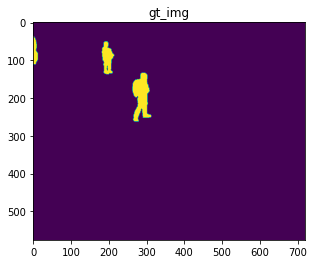

(500, 576, 720)


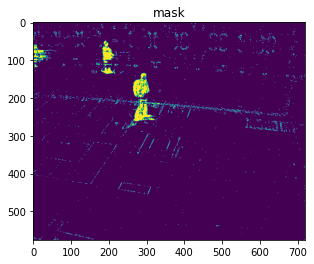

[[ 265  135   44   65 1602]
 [ 248  202   74   79 1544]
 [ 182   49   34   59  986]
 ...
 [ 512  230    1    1    1]
 [ 583   68    1    1    1]
 [ 719  575    1    1    1]]


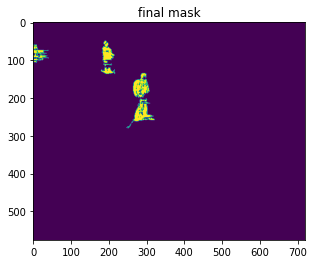

[410] f1:0.753695	recall:0.687304	 Time: 0.16287


In [156]:
time_list = []
metrics_list = []  # f1score, recall
debug = 1

for i in [410]:
    # ground truth and raw image
    gt_img = np.array(Image.open(gt_files[i])).astype(np.int32) / 255.0
    gt_img = (gt_img > 0.5) * 1.0
    y_true = gt_img.ravel()
    if np.sum(y_true) < 100:
        continue
    
    raw_img = load_and_preprocess_image(raw_files[i], (p, q))
    if debug:
        plt.imshow(gt_img)
        plt.title("gt_img")
        plt.show()
    
    # GPA density estimator
    t1 = time.time()
    Omega2_star = K_tf(tick_tensor - raw_img, bandwidth_star)
    print(Omega2_star.shape)
    Omega1_star = Omega2_star * GPA_matrix2
    Omega1_star = tf.reduce_sum(Omega1_star, axis=0)
    Omega2_star = tf.reduce_sum(Omega2_star, axis=0)
    GPA_density = Omega1_star / Omega2_star
    
    # obtain mask
#     blur_len = 3
#     avg_blur_2d = AveragePooling2D(pool_size=(blur_len, blur_len), strides=1, padding='same')
#     mask = tf.reshape(GPA_density, GPA_density.shape + (1, 1,))
#     mask = avg_blur_2d(mask)
#     mask = tf.squeeze(mask)
    mask = (GPA_density.numpy() < 3) * 1.0
    if debug:
        plt.imshow(mask)
        plt.title("mask")
        plt.show()

    # adjust mask
    mask_uint8 = mask.astype(np.uint8)
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8)
    # stats = np.insert(stats, 5, stats[:, 2] * stats[:, 3], axis=1)
    stats = stats[np.argsort(-stats[:, 4])] # 按照area排序
    stats = stats[1:, ]                     # 去掉背景
    
    for k in range(stats.shape[0]):
        area = stats[k, 4]
        if area < 50:
            x1 = stats[k, 0]
            y1 = stats[k, 1]
            x2 = x1 + stats[k, 2]
            y2 = y1 + stats[k, 3]
            mask[y1:y2, x1:x2] = 0
    t2 = time.time()
    time_list.append(t2 - t1)
    if debug:
        print(stats)
        plt.imshow(mask)
        plt.title("final mask")
        plt.show()
    
    # metrics
    y_predict = mask.ravel()
    f1 = f1_score(y_true, y_predict)
    recall = recall_score(y_true, y_predict)
    metrics_list.append([f1, recall])
    print(f"[{i}] f1:{f1:5f}\trecall:{recall:5f}\t Time: {time_list[-1]:.5f}") 

In [482]:
np.mean(time_list)

0.0292406207636783

# R-PCA

In [27]:
i = 900                        # starting index
window = 100                    # window
D = np.zeros((window, p*q))    # each row is an image vectorization
for k in range(window):
    raw_img = load_img_np(raw_files[i+k])
    raw_vec = raw_img.ravel()
    D[k] = raw_vec

In [28]:
# from RobustPCA.spcp import StablePCP

# # spcp = StablePCP()
# # spcp.fit(M)
# # L = spcp.get_low_rank()
# # S = spcp.get_sparse()

In [29]:
# from RobustPCA.rpca import RobustPCA

# t1 = time.time()
# rpca = RobustPCA(tol = 1, max_iter=1000, use_fbpca=True) # max_rank=100, 
# rpca.fit(D)
# t2 = time.time()
# L = rpca.get_low_rank()
# S = rpca.get_sparse()

In [43]:
from r_pca import R_pca

In [44]:
# use R_pca to estimate the degraded data as L + S, where L is low rank, and S is sparse
rpca = R_pca(D)
L, S = rpca.fit(max_iter=10000, iter_print=1)

iteration: 1, error: 0.00020624810709867053


In [46]:
rpca.tol

AttributeError: 'R_pca' object has no attribute 'tol'

In [38]:
a = np.random.randn(9, 6) + 1j*np.random.randn(9, 6)
U, S, Vh = np.linalg.svd(a, full_matrices=True)

In [39]:
a.shape, U.shape, S.shape, Vh.shape

((9, 6), (9, 9), (6,), (6, 6))

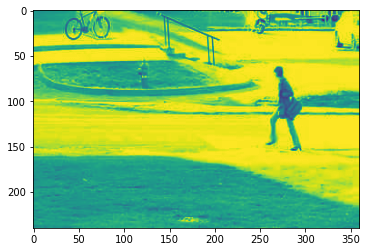

In [32]:
idx = 0

a = D[idx]
a = a.reshape((p, q))
plt.imshow(a)
plt.show()

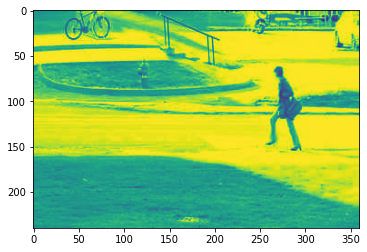

In [33]:
b = L[idx]
b = b.reshape((p, q))
plt.imshow(b)
plt.show()

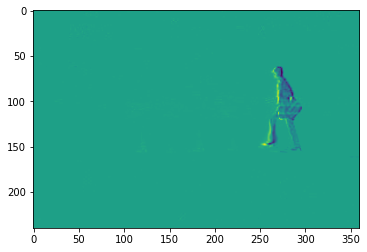

In [34]:
c = S[idx]
c = c.reshape((p, q))
plt.imshow(c)
plt.show()

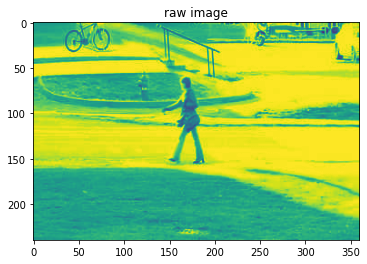

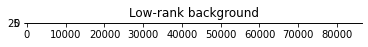

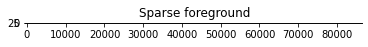

In [25]:
plt.imshow(raw_img)
plt.title("raw image")
plt.show()

plt.imshow(L)
plt.title("Low-rank background")
plt.show()

plt.imshow(S)
plt.title("Sparse foreground")
plt.show()